The point of this notebook is to do a quick prediction on some sample images with a pretrained network.

In [138]:
import sys

In [139]:
sys.path.append('../')

In [140]:
import cPickle as pickle
import re
import glob
import os

import time

import theano
import theano.tensor as T
import numpy as np
import pandas as p
import lasagne as nn

from utils import hms, architecture_string, get_img_ids_from_iter

In [141]:
%pylab inline

rcParams['figure.figsize'] = 16, 6
# rcParams['text.color'] = 'red'
# rcParams['xtick.color'] = 'red'
# rcParams['ytick.color'] = 'red'

Populating the interactive namespace from numpy and matplotlib


In [142]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

First we load the dump of the trained network.

In [143]:
dump_path = '../dumps/2015_07_17_123003.pkl'

In [144]:
model_data = pickle.load(open(dump_path, 'r'))

In [145]:
# Let's set the in and output layers to some local vars.
l_out = model_data['l_out']
l_ins = model_data['l_ins']

Some info about the architecture of the model:

In [146]:
num_params = nn.layers.count_params(l_out)
print "\n\t\tNumber of parameters: %d" % num_params

model_arch = architecture_string(model_data['l_out'])

model_arch += "\nNumber of parameters: %d.\n\n" % num_params

# Get some training/validation info.
selected_keys = ['acc_eval_train', 'acc_eval_valid',
                 'losses_eval_train', 'losses_eval_valid',
                 'metric_eval_train', 'metric_eval_valid',
                 'metric_cont_eval_train', 'metric_cont_eval_valid']
model_metrics = {key: model_data[key]
                 for key in selected_keys if key in model_data}

res_df = p.DataFrame(model_metrics)

model_arch += 'BEST/LAST KAPPA TRAIN: %.3f - %.3f.\n' % (
    res_df.metric_eval_train.max(),
    res_df.metric_eval_train.iloc[-1]
)
model_arch += 'BEST/LAST KAPPA VALID: %.3f - %.3f.\n' % (
    res_df.metric_eval_valid.max(),
    res_df.metric_eval_valid.iloc[-1]
)

model_arch += '\nBEST/LAST ACC TRAIN: %.2f - %.2f.\n' % (
    res_df.acc_eval_train.max() * 100,
    res_df.acc_eval_train.iloc[-1] * 100
)

model_arch += 'BEST/LAST ACC VALID: %.2f - %.2f.\n' % (
    res_df.acc_eval_valid.max() * 100,
    res_df.acc_eval_valid.iloc[-1] * 100
)

model_arch += '\nTOTAL TRAINING TIME: %s' % \
              hms(model_data['time_since_start'])

print model_arch


		Number of parameters: 20923690
   0  InputLayer                   (64, 3, 512, 512)  
   1  Conv2DDNNLayer               (64, 32, 256, 256)  7 //2
   2  MaxPool2DDNNLayer            (64, 32, 127, 127)  3 //2
   3  Conv2DDNNLayer               (64, 32, 127, 127)  3 //1
   4  Conv2DDNNLayer               (64, 32, 127, 127)  3 //1
   5  MaxPool2DDNNLayer            (64, 32, 63, 63)  3 //2
   6  Conv2DDNNLayer               (64, 64, 63, 63)  3 //1
   7  Conv2DDNNLayer               (64, 64, 63, 63)  3 //1
   8  MaxPool2DDNNLayer            (64, 64, 31, 31)  3 //2
   9  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  10  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  11  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  12  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  13  MaxPool2DDNNLayer            (64, 128, 15, 15)  3 //2
  14  Conv2DDNNLayer               (64, 256, 15, 15)  3 //1
  15  Conv2DDNNLayer               (64, 256, 15, 15)  3 //1
  16  Conv2

Some more kappa specific metrics:

In [147]:
train_conf_mat, hist_rater_a, \
        hist_rater_b, train_nom, \
        train_denom = model_data['metric_extra_eval_train'][-1]

In [148]:
valid_conf_mat, hist_rater_a, \
        hist_rater_b, valid_nom, \
        valid_denom = model_data['metric_extra_eval_valid'][-1]

In [149]:
# Normalised train confusion matrix (with argmax decoding).
print train_conf_mat / train_conf_mat.sum()

[[ 0.715  0.04   0.027  0.     0.   ]
 [ 0.014  0.016  0.008  0.     0.   ]
 [ 0.011  0.016  0.078  0.002  0.001]
 [ 0.     0.     0.03   0.02   0.001]
 [ 0.     0.     0.003  0.001  0.016]]


In [150]:
# Normalised validation confusion matrix (with argmax decoding).
print valid_conf_mat / valid_conf_mat.sum()

[[ 0.704  0.042  0.028  0.001  0.001]
 [ 0.011  0.016  0.008  0.     0.   ]
 [ 0.015  0.013  0.085  0.005  0.003]
 [ 0.     0.     0.029  0.017  0.004]
 [ 0.001  0.     0.003  0.002  0.014]]


Setting up some Theano / Lasagne things to get some predictions.

In [151]:
chunk_size = model_data['chunk_size'] * 2
batch_size = model_data['batch_size']

print "Batch size: %i." % batch_size

Batch size: 64.


In [152]:
output = nn.layers.get_output(l_out, deterministic=True)
input_ndims = [len(nn.layers.get_output_shape(l_in))
               for l_in in l_ins]
xs_shared = [nn.utils.shared_empty(dim=ndim)
             for ndim in input_ndims]
idx = T.lscalar('idx')

givens = {}
for l_in, x_shared in zip(l_ins, xs_shared):
    givens[l_in.input_var] = x_shared[idx * batch_size:(idx + 1) * batch_size]

compute_output = theano.function(
    [idx],
    output,
    givens=givens,
    on_unused_input='ignore'
)

In [153]:
# Do transformations per patient instead?
if 'paired_transfos' in model_data:
    paired_transfos = model_data['paired_transfos']
else:
    paired_transfos = False
    
print paired_transfos

True


We're going to test on some train images, so loading the training set labels.

In [154]:
train_labels = p.read_csv(os.path.join('../data/trainLabels.csv'))

In [155]:
print train_labels.head(5)

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


In [156]:
# Get al patient ids.
patient_ids = sorted(set(get_img_ids_from_iter(train_labels.image)))

In [157]:
# If we did all the patients we would need quite a few chunks.
print "Chunk size: %i.\n" % chunk_size

num_chunks = int(np.ceil((2 * len(patient_ids)) / float(chunk_size)))

Chunk size: 256.



In [158]:
# Where all the images are located: 
# it looks for [img_dir]/[patient_id]_[left or right].jpeg
img_dir = '/media/user/Extended_ext4/train_ds2_crop/'

Using the DataLoader to set up the parameters, you could replace it with something much simpler.

In [159]:
from generators import DataLoader

In [160]:
data_loader = DataLoader()
new_dataloader_params = model_data['data_loader_params']
new_dataloader_params.update({'images_test': patient_ids})
new_dataloader_params.update({'labels_test': train_labels.level.values})
new_dataloader_params.update({'prefix_train': img_dir})
data_loader.set_params(new_dataloader_params)

The next function is going to iterate over a test generator to get the outputs.

In [161]:
def do_pred(test_gen):
    outputs = []

    for e, (xs_chunk, chunk_shape, chunk_length) in enumerate(test_gen()):
        num_batches_chunk = int(np.ceil(chunk_length / float(batch_size)))

        print "Chunk %i/%i" % (e + 1, num_chunks)

        print "  load data onto GPU"
        for x_shared, x_chunk in zip(xs_shared, xs_chunk):
            x_shared.set_value(x_chunk)

        print "  compute output in batches"
        outputs_chunk = []
        for b in xrange(num_batches_chunk):
            out = compute_output(b)
            outputs_chunk.append(out)

        outputs_chunk = np.vstack(outputs_chunk)
        outputs_chunk = outputs_chunk[:chunk_length]  # truncate to the right length

        outputs.append(outputs_chunk)

    return np.vstack(outputs), xs_chunk

We get the default "no transformation" parameters for the model.

In [162]:
no_transfo_params = model_data['data_loader_params']['no_transfo_params']

print no_transfo_params

{'extra_width_crop': True, 'rotation_before_resize': False, 'crop_height': False, 'resize_pad': False, 'keep_aspect_ratio': False}


And set up the test generator on the first 256 patients of the training set (512 images).

In [163]:
# The default gen with "no transfos".
test_gen = lambda: data_loader.create_fixed_gen(
    data_loader.images_test[:128*2],
    chunk_size=chunk_size,
    prefix_train=img_dir,
    prefix_test=img_dir,
    transfo_params=no_transfo_params,
    paired_transfos=paired_transfos,
)

Then we can get some predictions.

In [164]:
%%time
outputs_orig, chunk_orig = do_pred(test_gen)

Chunk 1/138
  load data onto GPU
  compute output in batches
Chunk 2/138
  load data onto GPU
  compute output in batches
CPU times: user 15.5 s, sys: 2.8 s, total: 18.3 s
Wall time: 17.5 s


Explore some of the predictions.

In [165]:
from metrics import continuous_kappa

In [166]:
outputs_labels = np.argmax(outputs_orig, axis=1)

kappa_eval = continuous_kappa(
                outputs_labels,
                train_labels.level.values[:outputs_labels.shape[0]],
            )

metric, conf_mat, \
    hist_rater_a, hist_rater_b, \
    nom, denom = kappa_eval
    
print 'Kappa %.4f' % metric, '\n'
print conf_mat, '\n'
print nom, '\n'
print nom / nom.sum(), nom.sum()

Kappa 0.8723 

[[362  23  15   0   0]
 [ 12   4   5   0   0]
 [  4   6  42   2   0]
 [  0   0   9  10   2]
 [  0   0   1   1  14]] 

[[ 0.     1.438  3.75   0.     0.   ]
 [ 0.75   0.     0.312  0.     0.   ]
 [ 1.     0.375  0.     0.125  0.   ]
 [ 0.     0.     0.562  0.     0.125]
 [ 0.     0.     0.25   0.062  0.   ]] 

[[ 0.     0.164  0.429  0.     0.   ]
 [ 0.086  0.     0.036  0.     0.   ]
 [ 0.114  0.043  0.     0.014  0.   ]
 [ 0.     0.     0.064  0.     0.014]
 [ 0.     0.     0.029  0.007  0.   ]] 8.75


Bit high of a kappa but this is because: 

1. There is a gap between the train and validation kappa.
2. This is a small sample.

Some extra information. 

Let's also make a difference between the validation set and the rest.

In [167]:
train_imgs = set(data_loader.images_train_0)
valid_idx = [0  if img in train_imgs else 1 for img in data_loader.images_test]

In [168]:
df_preds = p.DataFrame([train_labels.image[:outputs_labels.shape[0]],
                        outputs_labels,
                        train_labels.level.values[:outputs_labels.shape[0]],
                       np.repeat(valid_idx, 2)[:outputs_labels.shape[0]]]).T
df_preds.columns = ['image', 'pred', 'true', 'valid']

The misclassifications:

In [169]:
df_preds[df_preds.pred != df_preds.true]

image pred true valid
4      15_left    0    1     0
5     15_right    0    2     0
9     17_right    0    1     0
22     30_left    0    1     0
23    30_right    0    2     0
28     36_left    0    1     0
30     40_left    1    2     0
31    40_right    1    0     0
43    51_right    1    0     0
78     78_left    0    2     0
79    78_right    0    2     0
84     82_left    3    2     0
91    99_right    2    3     0
102   114_left    0    1     0
103  114_right    0    1     0
106   117_left    1    0     0
120   149_left    1    0     0
121  149_right    1    0     0
123  155_right    0    2     0
142   170_left    1    0     0
150   178_left    0    1     0
151  178_right    0    1     0
154   184_left    0    2     0
155  184_right    0    2     0
164   195_left    0    2     1
165  195_right    0    2     1
173  204_right    0    1     0
180   214_left    0    1     0
188   219_left    0    2     0
196   227_left    0    1     0
..         ...  ...  ...   ...
319  375_right    2    0     0
322   378_left    3    2     0
337  393_right    0    1     0
341  396_right    1    2     0
350   405_left    3    4     0
351  405_right    3    4     0
360   417_left    2    1     0
361  417_right    2    1     0
366   421_left    2    1     0
367  421_right    1    0     0
379  435_right    0    1     0
384   439_left    4    2     0
386   444_left    0    2     0
387  444_right    1    2     0
388   445_left    1    0     0
389  445_right    1    0     0
402   458_left    4    3     1
404   460_left    2    0     0
405  460_right    2    0     0
407  465_right    1    0     0
421  487_right    0    1     0
438   508_left    3    2     0
451  525_right    0    1     0
452   527_left    0    1     0
453  527_right    0    2     0
472   560_left    2    1     0
479  568_right    0    1     0
494   607_left    1    2     1
495  607_right    0    1     1
496   609_left    2    3     0

[80 rows x 4 columns]

Let's look at some sample activations:

In [170]:
diag_out = theano.function(
    [idx],
    nn.layers.get_output(nn.layers.get_all_layers(l_out), deterministic=True),
    givens=givens,
    on_unused_input="ignore"
)

In [171]:
diag_result = np.asarray(diag_out(0))

In [172]:
# The input images.
diag_result[0].shape

(64, 3, 512, 512)

In [173]:
def plot_rollaxis(im, figsize=(15, 15), 
                  zmuv_mean=data_loader.zmuv_mean, 
                  zmuv_std=data_loader.zmuv_std,
                 norm=True, ax=None):
    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)
        
    if norm:
        ax.imshow((zmuv_std[0] + 0.05) * np.rollaxis(im, 0, 3) + zmuv_mean[0])
    else:
        ax.imshow(np.rollaxis(im, 0, 3))
        
    return ax

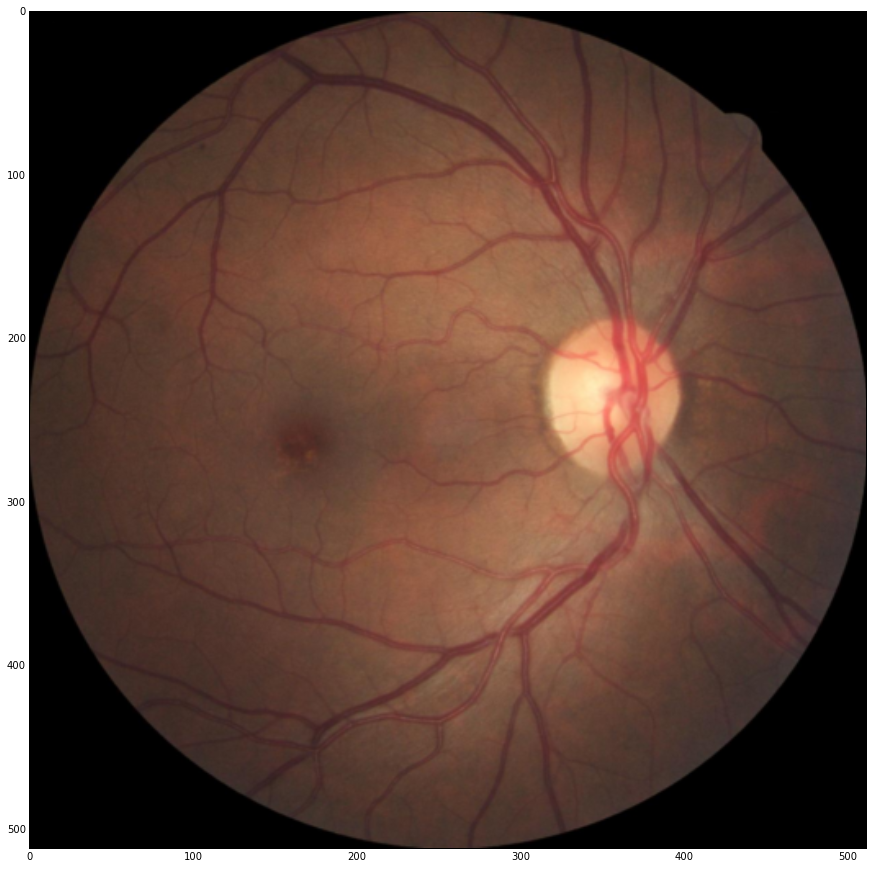

In [174]:
plot_rollaxis(diag_result[0][1])

Do keep in mind, we work in "chunks" and only the last "chunk" is still loaded on the GPU.

Since a chunk is 256 images, we can subset those predictions.

In [175]:
df_chunk = df_preds[-128*2:]
df_chunk['idx'] = np.repeat(range(128), 2)

print df_chunk

         image pred true valid  idx
256   301_left    0    0     0    0
257  301_right    0    1     0    0
258   307_left    0    0     0    1
259  307_right    0    0     0    1
260   310_left    0    0     0    2
261  310_right    0    0     0    2
262   311_left    0    0     1    3
263  311_right    0    0     1    3
264   314_left    0    0     1    4
265  314_right    0    0     1    4
266   316_left    0    0     0    5
267  316_right    0    0     0    5
268   317_left    2    2     0    6
269  317_right    2    2     0    6
270   318_left    0    0     0    7
271  318_right    0    0     0    7
272   320_left    2    1     0    8
273  320_right    2    2     0    8
274   322_left    1    0     0    9
275  322_right    0    0     0    9
276   323_left    0    0     0   10
277  323_right    0    0     0   10
278   325_left    0    2     0   11
279  325_right    0    2     0   11
280   326_left    4    4     0   12
281  326_right    4    4     0   12
282   328_left    2    2    

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [176]:
# To print some output for a layer. (Hacky / quick.)
def print_output(layer_out, norm=False):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 200))

    for i, elem in enumerate(np.asarray(layer_out)[:2]):
        print elem.shape
        
        if norm:
            ax[i].imshow(np.concatenate(elem, axis=0), cmap=plt.cm.gray, 
                         vmin=np.asarray(layer_out).min(),
                         vmax=np.asarray(layer_out).max())
        else:        
            ax[i].imshow(np.concatenate(elem, axis=0), cmap=plt.cm.gray)

So, if we take index 8, we should see:

In [177]:
idx = 8

In [178]:
df_chunk[df_chunk.idx == idx]

image pred true valid  idx
272   320_left    2    1     0    8
273  320_right    2    2     0    8

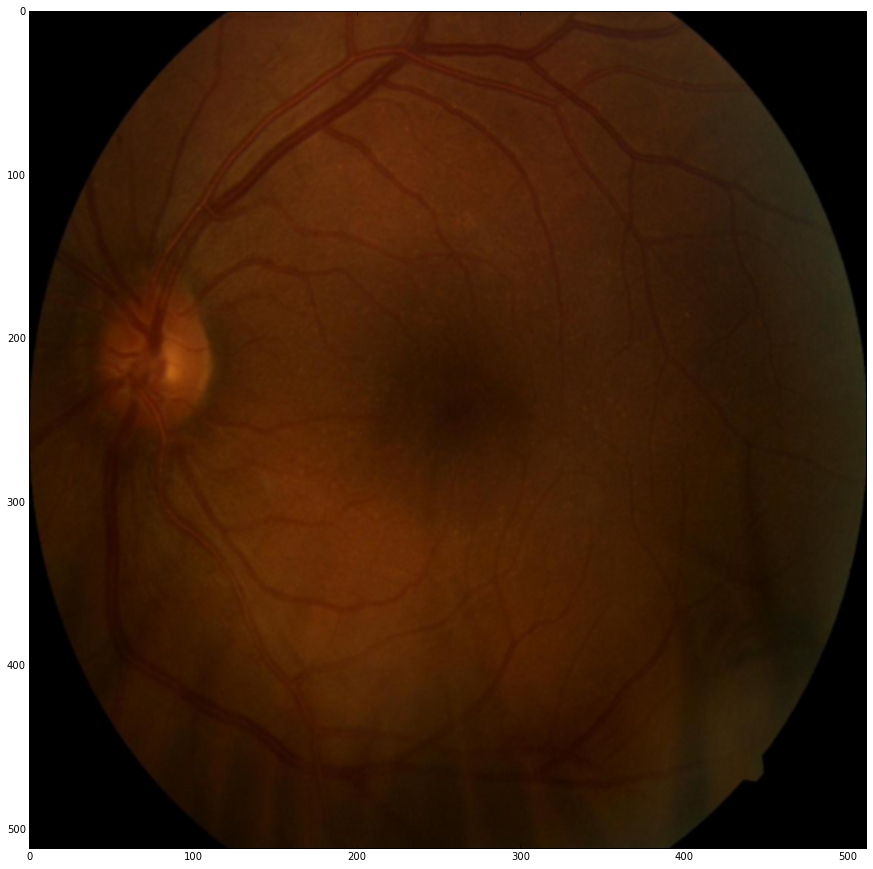

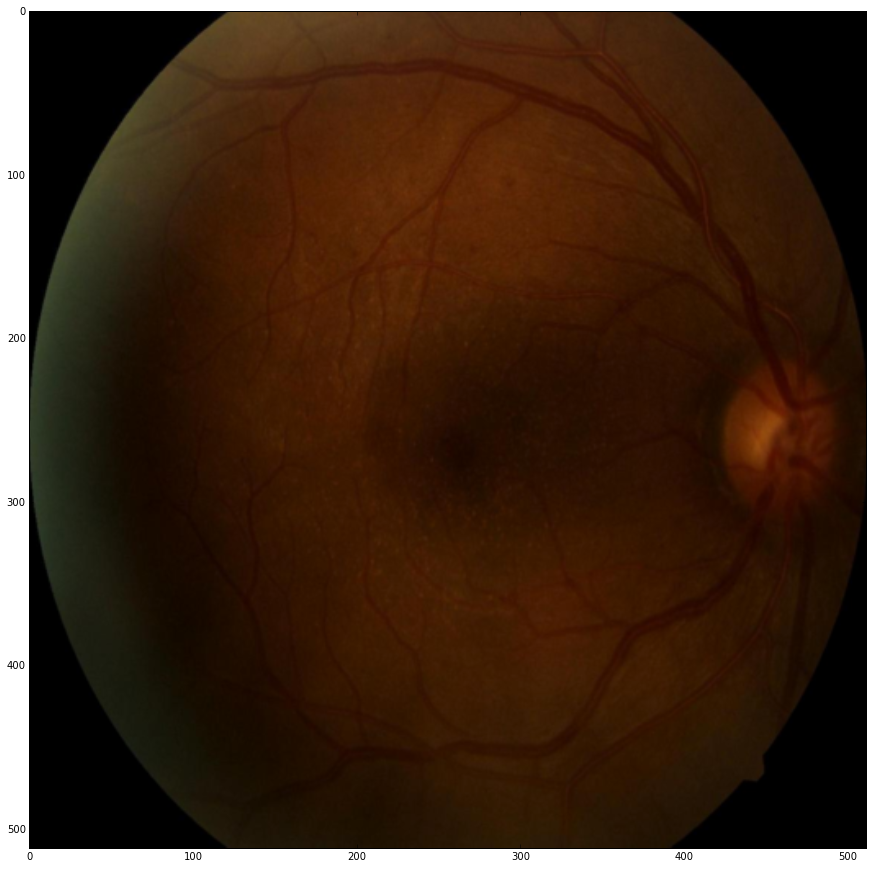

In [179]:
plot_rollaxis(diag_result[0][2*idx+0])  # Left.
plot_rollaxis(diag_result[0][2*idx+1])  # Right.

Let's see the output of one filter of the first layer for the left eye of that patient:

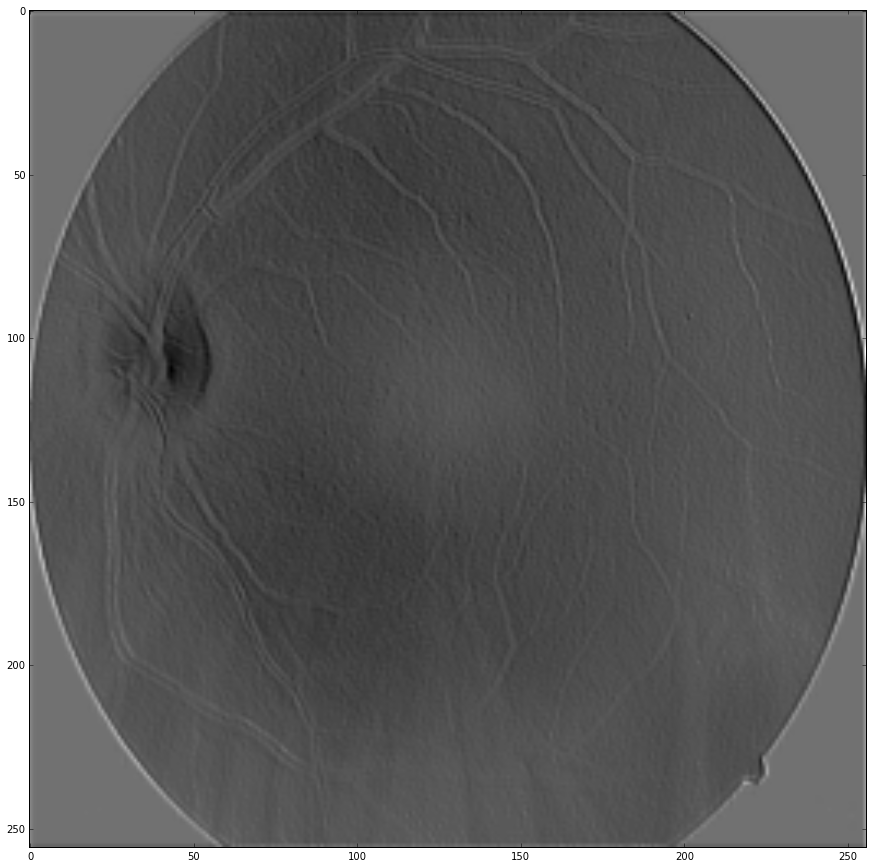

In [180]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(diag_result[1][2*idx+0][24], cmap=plt.cm.gray)

If you do this for some images with microaneurysms, most of the time you will see them getting "detected".

You can then also follow this "detection" through the following layers.

To get the activations for both eyes for a certain layer, we can do:

(32, 127, 127)
(32, 127, 127)


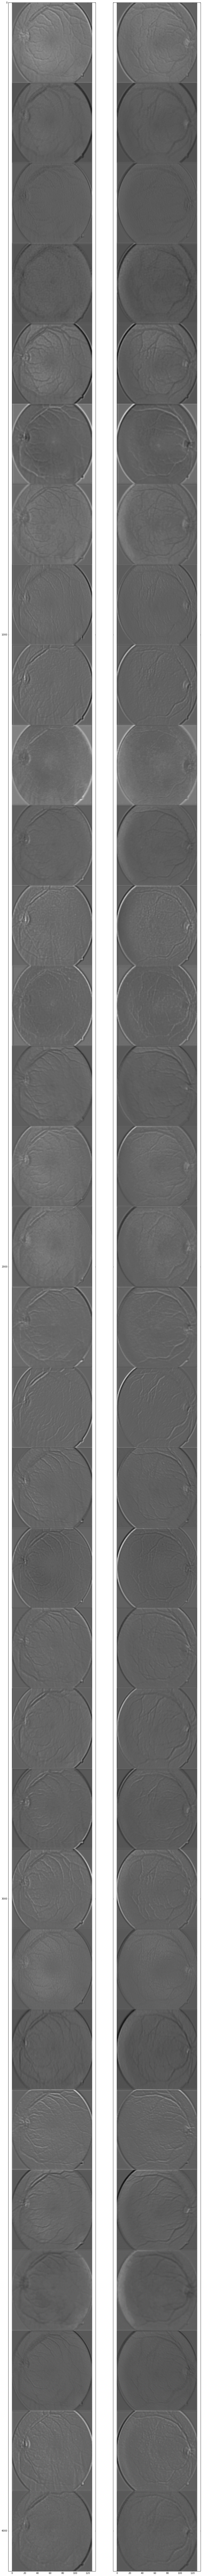

In [181]:
print_output(diag_result[4][2*idx:], norm=False)